<h2>Linear Predictive Coding (LPC)</h2>

In [ ]:
!wget https://raw.githubusercontent.com/phonetics-spbu/phonetics-spbu.github.io/main/public/courses/dsp/audio/ktc0001.wav

In [ ]:
import numpy as np
from math import floor
import scipy.signal as signal
from scipy.signal import lfilter, resample
from scipy.signal.windows import hann
from numpy.random import randn

In [ ]:
"""
Разбиваем сигнал на перекрывающиеся фреймы

x - сигнал
w - веса оконной функции
R - коэффициент перекрытия

Возвращаем:

B - список перекрывающихся фреймов
"""
def create_overlapping_blocks(x, w, R = 0.5):
    n = len(x)
    nw = len(w)
    step = floor(nw * (1 - R))
    nb = floor((n - nw) / step) + 1

    B = np.zeros((nb, nw))


    for i in range(nb):
        offset = i * step
        B[i, :] = w * x[offset : nw + offset]

    return B


"""
Создаем матрицу LPC

x - сигнал
p - порядок LPC
"""
def make_matrix_X(x, p):
    n = len(x)
    # [x_n, ..., x_1, 0, ..., 0]
    xz = np.concatenate([x[::-1], np.zeros(p)])

    X = np.zeros((n - 1, p))
    for i in range(n - 1):
        offset = n - 1 - i
        X[i, :] = xz[offset : offset + p]
    return X

"""
Решаем матрицу LPC (ищем коэффициенты a)

x - сигнал
p - порядок LPC

a - коэффициенты LPC
g - дисперсия источника (будем считать, что источник шумовой, поэтому сохраним только его дисперсию)
e - источник
"""
def solve_lpc(x, p, ii):
    b = x[1:].T

    X = make_matrix_X(x, p)

    a = np.linalg.lstsq(X, b)[0]

    e = b.T - np.dot(X, a)
    g = np.var(e)

    return [a, g]

"""
Кодируем сигнал с перекрытием 50%

x - сигнал
p - порядок LPC
nw - размер окна

A - коэффициенты линейного предсказания
G - дисперсия источника
e - источник
"""
def lpc_encode(x, p, w):
    B = create_overlapping_blocks(x, w)

    [nb, nw] = B.shape

    A = np.zeros((p, nb))
    G = np.zeros((1, nb))
    E = np.zeros((1, nb))

    for i in range(nb):
        [a, g] = solve_lpc(B[i, :], p, i)

        A[:, i] = a
        G[:, i] = g

    return [A, G]

In [ ]:
"""
Восстанавливаем сигнал из перекрывающихся блоков

B - список перекрывающихся блоков

x - восстановленный сигнал
"""
def add_overlapping_blocks(B, R = 0.5):
    [count, nw] = B.shape
    step = floor(nw * R)

    n = (count-1) * step + nw

    x = np.zeros((n, ))

    for i in range(count):
        offset = i * step
        x[offset : nw + offset] += B[i, :]

    return x

"""
Восстанавливаем сигнал, источник - белый шум с известной дисперсией, a - коэффициенты фильтра
"""
def run_source_filter(a, g, block_size):
    src = np.sqrt(g)*randn(block_size, 1)

    b = np.concatenate([np.array([-1]), a])

    x_hat = lfilter([1], b.T, src.T).T
    return np.squeeze(x_hat)


"""
Декодируем сигнал по коэффициентам линейного предсказания

* A - матрица коэффициентов линейного предсказания
* G - дисперсия сигнала
* w - оконная функция
"""
def lpc_decode(A, G, w):

    [ne, n] = G.shape
    nw = len(w)
    [p, _] = A.shape

    B_hat = np.zeros((n, nw))

    for i in range(n):
        B_hat[i,:] = run_source_filter(A[:, i], G[:, i], nw)

    x_hat = add_overlapping_blocks(B_hat);

    return x_hat

In [ ]:
[sample_rate, amplitudes] = scipy.io.wavfile.read(r'ktc0001.wav')
amplitudes = np.array(amplitudes)

# нормализуем
amplitudes = 0.9*amplitudes/max(abs(amplitudes));

# понижаем частоту дискретизации до 8кГц
target_sample_rate = 8000
target_size = int(len(amplitudes)*target_sample_rate/sample_rate)
amplitudes = resample(amplitudes, target_size)
sample_rate = target_sample_rate

# окно Ханна, 30мс
sym = False # periodic
w = hann(floor(0.03*sample_rate), sym)

# Кодируем
p = 16 # порядок предсказания
[A, G] = lpc_encode(amplitudes, p, w)

original_size = len(amplitudes)
model_size = A.size + G.size
print('Original signal size:', original_size)
print('Encoded signal size:', model_size)
print('Data reduction:', original_size/model_size)

xhat = lpc_decode(A, G, w)

scipy.io.wavfile.write("example.wav", sample_rate, xhat)
print('done')

Original signal size: 16412
Encoded signal size: 2295
Data reduction: 7.15119825708061
done


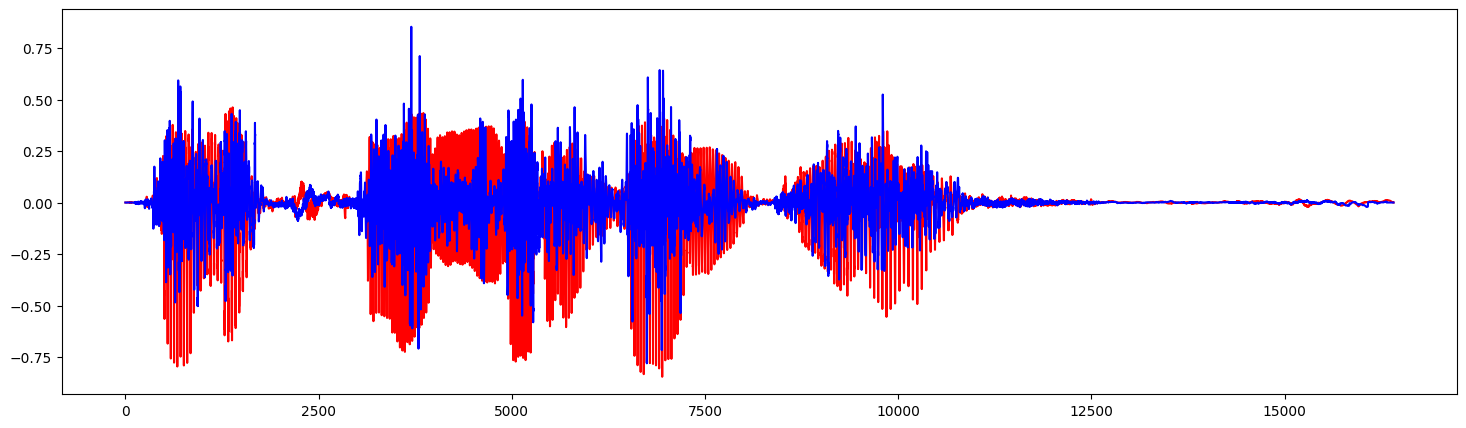

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 5))

n = len(amplitudes)
ts = np.array(range(0, n))
plt.plot(ts, amplitudes, 'r')

xhat_padded = np.concatenate([xhat, np.zeros(n - len(xhat))])
plt.plot(ts, xhat_padded, 'b')

plt.show()

In [ ]:
import IPython.display as ipd

In [ ]:
ipd.Audio(data=amplitudes, rate=sample_rate)

In [ ]:
ipd.Audio(data=xhat, rate=sample_rate)